In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import timm
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import os
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),             # Resize the image to 256x256 pixels
    transforms.ToTensor(),              # Convert the image to a tensor
])

In [ ]:
data_dir = './'
full_dataset = datasets.Food101(root=data_dir, download = True, transform=transform)

100%|██████████| 4996278331/4996278331 [00:28<00:00, 177213261.89it/s]


Extracting ./food-101.tar.gz to ./


In [ ]:
from shutil import copy
from collections import defaultdict

# Function to prepare data
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...
Copying Done!


In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...
Copying Done!


In [ ]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((200,200)), # Crop a random portion of image and resize it to a given size.
    transforms.RandomHorizontalFlip(), # Horizontally flip the given image randomly
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image, Mean and Std of image as also used when training the model
])

transform_test = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
data_dir_train = './food-101/train'
data_dir_test = './food-101/test'

train_dataset = datasets.ImageFolder(root=data_dir_train, transform=transform_train)
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform_test)

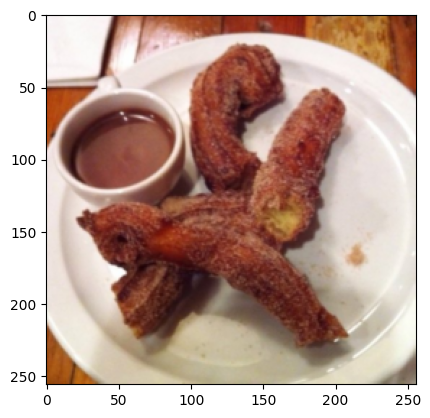

In [ ]:
image_tensor = full_dataset[0][0]
image_numpy = image_tensor.numpy()
image_numpy = image_numpy.transpose((1, 2, 0))
plt.imshow(image_numpy)
plt.show()

In [ ]:
num_classes = 101
batch_size = 32

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
total_train = len(train_dataset)
total_val =  len(test_dataset)

print(f"Size of training set: {total_train}")
print(f"Size of validation set: {total_val}")

Size of training set: 75750
Size of validation set: 25250


In [ ]:
def training(tuned_model, train_loader, val_loader, criterion, optimizer):
  # Initialize lists to store epoch-wise values
  train_losses = []  # List to store training losses
  train_accuracies = []  # List to store training accuracies
  val_losses = []  # List to store validation losses
  val_accuracies = []  # List to store validation accuracies

  # Training loop
  num_epochs = 10  # Number of epochs for training
  for epoch in range(num_epochs):
      # Training
      tuned_model.train()  # Set the model to training mode
      running_train_loss = 0.0  # Initialize running training loss
      correct_train = 0  # Initialize number of correctly predicted training samples
      total_train = 0  # Initialize total number of training samples
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
          optimizer.zero_grad()  # Zero the parameter gradients
          outputs = tuned_model(inputs)  # Forward pass
          if isinstance(outputs, tuple):
              logits = outputs[0]  # Unpack logits if model returns tuple
          else:
              logits = outputs
          loss = criterion(logits, labels)  # Calculate loss
          loss.backward()  # Backward pass
          optimizer.step()  # Optimize parameters

          running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
          _, predicted = torch.max(logits, 1)  # Get predicted labels
          total_train += labels.size(0)  # Increment total training samples
          correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

      # Calculate epoch-wise training loss and accuracy
      epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
      train_accuracy = correct_train / total_train  # Training accuracy

      # Validation
      tuned_model.eval()  # Set the model to evaluation mode
      running_val_loss = 0.0  # Initialize running validation loss
      correct_val = 0  # Initialize number of correctly predicted validation samples
      total_val = 0  # Initialize total number of validation samples
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
              outputs = tuned_model(inputs)  # Forward pass
              if isinstance(outputs, tuple):
                  logits = outputs[0]  # Unpack logits if model returns tuple
              else:
                  logits = outputs
              loss = criterion(logits, labels)  # Calculate loss

              running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
              _, predicted = torch.max(logits, 1)  # Get predicted labels
              total_val += labels.size(0)  # Increment total validation samples
              correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

      # Calculate epoch-wise validation loss and accuracy
      epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Average validation loss
      val_accuracy = correct_val / total_val  # Validation accuracy

      # Append values to lists
      train_losses.append(epoch_train_loss)  # Append training loss
      train_accuracies.append(train_accuracy)  # Append training accuracy
      val_losses.append(epoch_val_loss)  # Append validation loss
      val_accuracies.append(val_accuracy)  # Append validation accuracy

      # Print epoch results
      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}')

  return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def plot_accuracies(train_gn, val_gn, train_mn, val_mn, train_nn, val_nn):
  epochs = range(1, len(train_gn) + 1)  # Generate the range of epochs starting from 1

  # Create a figure and a set of subplots
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

  # Plot data on each subplot
  axs[0].plot(epochs, train_gn, label = "Training")  # Plot on the first ax
  axs[0].plot(epochs, val_gn, label="Validation")  # Plot on the first ax
  axs[0].set_title('Accuracies for GoogLeNet')
  axs[0].set_xlabel('EPOCH')
  axs[0].set_ylabel('ACCURACY')
  axs[0].legend()

  axs[1].plot(epochs, train_mn, label = "Training")  # Plot on the first ax
  axs[1].plot(epochs, val_mn, label="Validation")  # Plot on the first ax
  axs[1].set_title('Accuracies for MobileNetv3')
  axs[1].set_xlabel('EPOCH')
  axs[1].set_ylabel('ACCURACY')
  axs[1].legend()

  axs[2].plot(epochs, train_nn, label = "Training")  # Plot on the first ax
  axs[2].plot(epochs, val_nn, label="Validation")  # Plot on the first ax
  axs[2].set_title('Accuracies for NasNet')
  axs[2].set_xlabel('EPOCH')
  axs[2].set_ylabel('ACCURACY')
  axs[2].legend()


  # Adjust layout to prevent overlap
  plt.tight_layout()

  # Display the plots
  plt.show()


In [ ]:
def plot_losses(train_gn, val_gn, train_mn, val_mn, train_nn, val_nn):
  epochs = range(1, len(train_gn) + 1)

  # Create a figure and a set of subplots
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  # Plot data on each subplot
  axs[0].plot(epochs, train_gn, label = "Training")
  axs[0].plot(epochs, val_gn, label="Validation")
  axs[0].set_title('Losses for GoogLeNet')
  axs[0].set_xlabel('EPOCH')
  axs[0].set_ylabel('LOSSES')
  axs[0].legend()

  axs[1].plot(epochs, train_mn, label = "Training")
  axs[1].plot(epochs, val_mn, label="Validation")
  axs[1].set_title('Losses for MobileNetv3')
  axs[1].set_xlabel('EPOCH')
  axs[1].set_ylabel('LOSSES')
  axs[1].legend()

  axs[2].plot(epochs, train_nn, label = "Training")
  axs[2].plot(epochs, val_nn, label="Validation")
  axs[2].set_title('Losses for NasNet')
  axs[2].set_xlabel('EPOCH')
  axs[2].set_ylabel('LOSSES')
  axs[2].legend()
  plt.tight_layout()

  # Display the plots
  plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#customized googlenet
class ModifiedGoogLeNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(ModifiedGoogLeNet, self).__init__()
        # Load the pre-trained GoogLeNet model
        self.feature_extractor = models.googlenet(pretrained=True)
        for param in self.feature_extractor.parameters():
          param.requires_grad = False

        # Remove the original fully connected layer
        self.feature_extractor.fc = nn.Identity()

        # Add global average pooling
        self.feature_extractor.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_extractor.dropout = nn.Dropout(0.2)

        # Add three fully connected layers
        self.fc1 = nn.Linear(1024, 1000)  # First fully connected layer
        self.fc2 = nn.Linear(1000, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Final fully connected layer mapping to the number of classes

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)

        # Forward passes through the fully connected layers
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
gnet = ModifiedGoogLeNet(num_classes, pretrained=True)

In [ ]:
gnet.to(device)

ModifiedGoogLeNet(
  (feature_extractor): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnet.parameters(), lr=0.0001) # optimizer

In [ ]:
train_loss_gn, val_loss_gn, train_acc_gn, val_acc_gn = training(gnet, train_loader, val_loader, criterion, optimizer)

Epoch [1/10], Train Loss: 3.5345, Train Accuracy: 19.06%, Val Loss: 4.5571, Val Accuracy: 16.30%
Epoch [2/10], Train Loss: 2.9318, Train Accuracy: 29.24%, Val Loss: 4.6201, Val Accuracy: 18.20%
Epoch [3/10], Train Loss: 2.8051, Train Accuracy: 31.86%, Val Loss: 4.5037, Val Accuracy: 19.17%
Epoch [4/10], Train Loss: 2.7337, Train Accuracy: 33.32%, Val Loss: 4.7430, Val Accuracy: 19.28%
Epoch [5/10], Train Loss: 2.6828, Train Accuracy: 34.60%, Val Loss: 4.6066, Val Accuracy: 20.68%
Epoch [6/10], Train Loss: 2.6465, Train Accuracy: 35.10%, Val Loss: 4.5313, Val Accuracy: 20.59%
Epoch [7/10], Train Loss: 2.6099, Train Accuracy: 36.17%, Val Loss: 4.6597, Val Accuracy: 21.06%
Epoch [8/10], Train Loss: 2.5792, Train Accuracy: 36.77%, Val Loss: 4.7653, Val Accuracy: 21.81%
Epoch [9/10], Train Loss: 2.5516, Train Accuracy: 37.24%, Val Loss: 4.7052, Val Accuracy: 21.50%
Epoch [10/10], Train Loss: 2.5254, Train Accuracy: 38.00%, Val Loss: 4.5999, Val Accuracy: 22.38%


In [ ]:
models.mobilenet_v3_large(pretrained=True) #mobilenet_v3 default model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
# Customized Mobilenet
class ModifiedMobilenet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(ModifiedMobilenet, self).__init__()
        # Load the pre-trained GoogLeNet model
        self.feature_extractor = models.mobilenet_v3_large(pretrained=True)
        for param in self.feature_extractor.parameters():
          param.requires_grad = False

        # Remove the original fully connected layer
        self.feature_extractor.classifier = nn.Identity()

        # Add global average pooling
        self.feature_extractor.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_extractor.dropout = nn.Dropout(0.2)

        # Add three fully connected layers
        self.fc1 = nn.Linear(960, 1000)  # First fully connected layer
        self.fc2 = nn.Linear(1000, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Final fully connected layer mapping to the number of classes

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)

        # Forward passes through the fully connected layers
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
mnet = ModifiedMobilenet(num_classes, pretrained = True)

In [ ]:
mnet.to(device)

ModifiedMobilenet(
  (feature_extractor): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Con

In [ ]:
criterion_mn = nn.CrossEntropyLoss()
optimizer_mn = optim.Adam(mnet.parameters(), lr=0.0001)

In [ ]:
train_loss_mn, val_loss_mn, train_acc_mn, val_acc_mn = training(mnet, train_loader, val_loader, criterion_mn, optimizer_mn)

Epoch [1/10], Train Loss: 3.1657, Train Accuracy: 26.33%, Val Loss: 3.9606, Val Accuracy: 12.93%
Epoch [2/10], Train Loss: 2.4995, Train Accuracy: 38.73%, Val Loss: 3.8175, Val Accuracy: 15.46%
Epoch [3/10], Train Loss: 2.3322, Train Accuracy: 42.50%, Val Loss: 3.8376, Val Accuracy: 15.40%
Epoch [4/10], Train Loss: 2.2212, Train Accuracy: 44.70%, Val Loss: 3.8069, Val Accuracy: 15.57%
Epoch [5/10], Train Loss: 2.1395, Train Accuracy: 46.48%, Val Loss: 3.8321, Val Accuracy: 15.81%
Epoch [6/10], Train Loss: 2.0700, Train Accuracy: 48.02%, Val Loss: 3.7403, Val Accuracy: 17.09%
Epoch [7/10], Train Loss: 2.0257, Train Accuracy: 48.73%, Val Loss: 3.8209, Val Accuracy: 16.75%
Epoch [8/10], Train Loss: 1.9663, Train Accuracy: 50.18%, Val Loss: 3.8108, Val Accuracy: 16.93%
Epoch [9/10], Train Loss: 1.9269, Train Accuracy: 50.88%, Val Loss: 3.7659, Val Accuracy: 17.58%
Epoch [10/10], Train Loss: 1.8863, Train Accuracy: 51.89%, Val Loss: 3.8380, Val Accuracy: 16.96%


In [ ]:
timm.create_model('nasnetalarge', pretrained=True) #default nasnet

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

NASNetALarge(
  (conv0): ConvNormAct(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): ActConvBn(
      (act): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (act_1): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2dSame(42, 42, kernel_size=(5, 5), stride=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act_2): ReLU(inplace=True)
      (separable_2): SeparableConv2d(
       

In [ ]:
#Customized Nasnet
class ModifiedNasnet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(ModifiedNasnet, self).__init__()
        # Load the pre-trained GoogLeNet model
        self.feature_extractor = timm.create_model('nasnetalarge', pretrained=True)
        for param in self.feature_extractor.parameters():
          param.requires_grad = False

        self.ninf = self.feature_extractor.last_linear.in_features
        # Remove the original fully connected layer
        self.feature_extractor.last_linear = nn.Identity()

        # Add three fully connected layers
        self.fc1 = nn.Linear(self.ninf, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 256)   # Second fully connected layer
        self.fc3 = nn.Linear(256, num_classes)  # Final fully connected layer mapping to the number of classes

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)

        # Forward passes through the fully connected layers
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
nasnet = ModifiedNasnet(num_classes, pretrained=True)

In [ ]:
nasnet.to(device)

ModifiedNasnet(
  (feature_extractor): NASNetALarge(
    (conv0): ConvNormAct(
      (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Identity()
      )
    )
    (cell_stem_0): CellStem0(
      (conv_1x1): ActConvBn(
        (act): ReLU()
        (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (comb_iter_0_left): BranchSeparables(
        (act_1): ReLU()
        (separable_1): SeparableConv2d(
          (depthwise_conv2d): Conv2dSame(42, 42, kernel_size=(5, 5), stride=(2, 2), groups=42, bias=False)
          (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
criterion_nasn = nn.CrossEntropyLoss()
optimizer_nasn = optim.Adam(nasnet.parameters(), lr=0.0001)

In [ ]:
train_loss_nn, val_loss_nn, train_acc_nn, val_acc_nn = training(nasnet, train_loader, val_loader, criterion_nasn, optimizer_nasn)

Epoch [1/10], Train Loss: 3.4568, Train Accuracy: 22.30%, Val Loss: 4.2483, Val Accuracy: 11.65%
Epoch [2/10], Train Loss: 2.8581, Train Accuracy: 32.48%, Val Loss: 4.3304, Val Accuracy: 12.26%
Epoch [3/10], Train Loss: 2.6938, Train Accuracy: 35.43%, Val Loss: 4.3262, Val Accuracy: 13.11%
Epoch [4/10], Train Loss: 2.6001, Train Accuracy: 37.04%, Val Loss: 4.2986, Val Accuracy: 13.96%
Epoch [5/10], Train Loss: 2.5292, Train Accuracy: 38.53%, Val Loss: 4.3603, Val Accuracy: 14.89%
Epoch [6/10], Train Loss: 2.4777, Train Accuracy: 39.30%, Val Loss: 4.4056, Val Accuracy: 13.94%
Epoch [7/10], Train Loss: 2.4314, Train Accuracy: 40.29%, Val Loss: 4.5419, Val Accuracy: 13.37%
Epoch [8/10], Train Loss: 2.3822, Train Accuracy: 41.33%, Val Loss: 4.3960, Val Accuracy: 15.07%
Epoch [9/10], Train Loss: 2.3509, Train Accuracy: 41.94%, Val Loss: 4.4895, Val Accuracy: 14.43%
Epoch [10/10], Train Loss: 2.3256, Train Accuracy: 42.43%, Val Loss: 4.6279, Val Accuracy: 14.48%


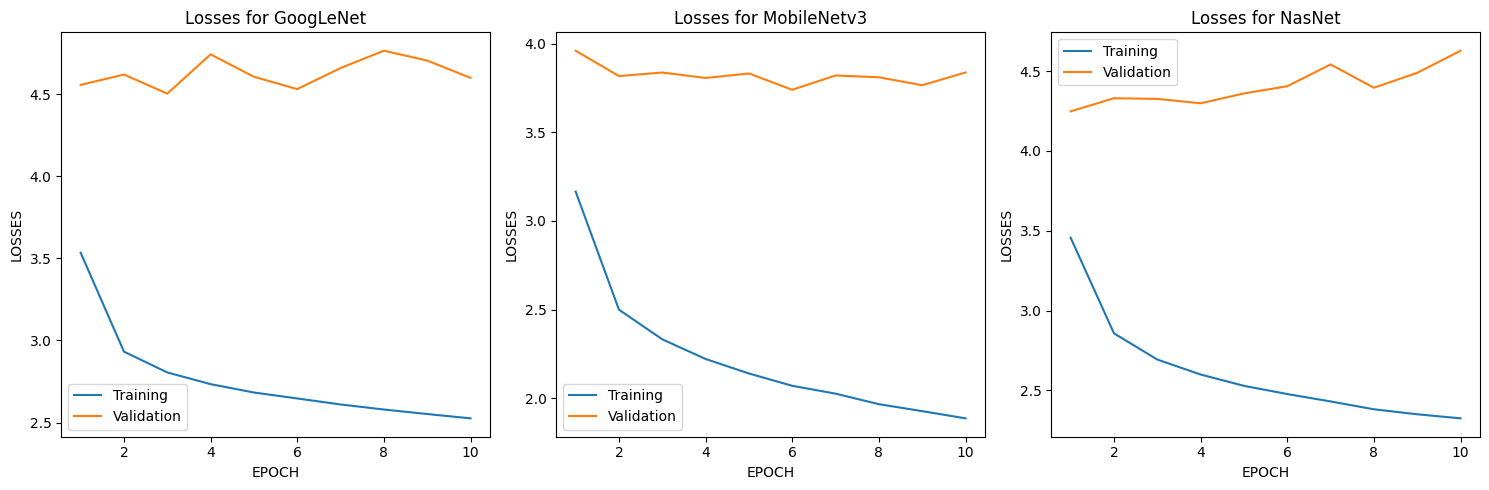

In [ ]:
plot_losses(train_loss_gn, val_loss_gn, train_loss_mn, val_loss_mn, train_loss_nn, val_loss_nn)

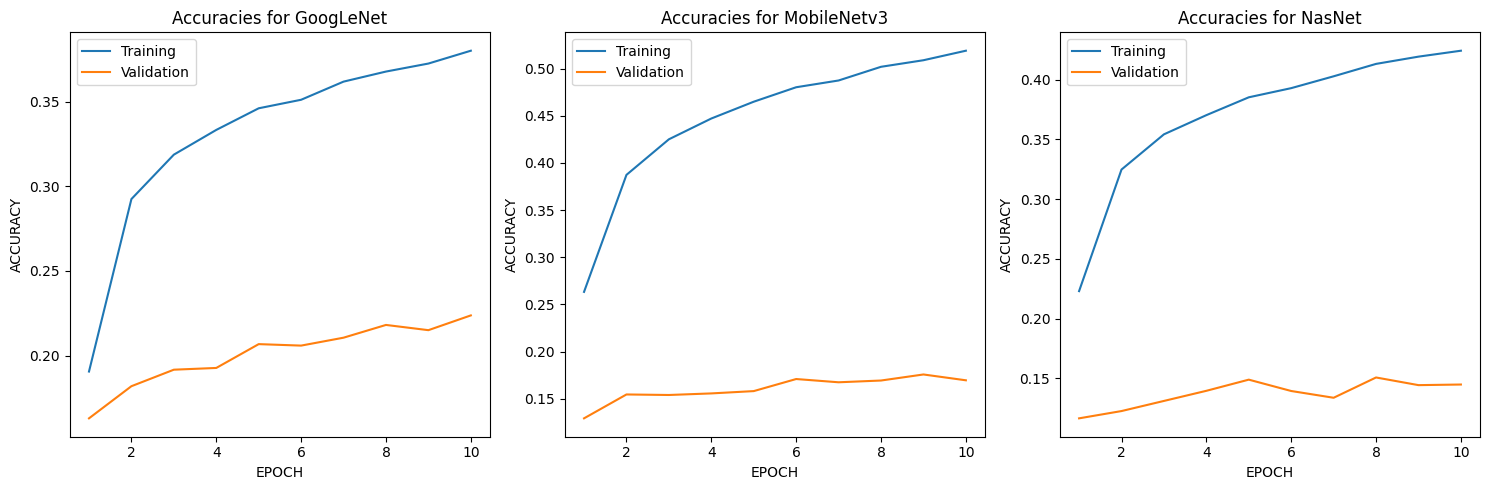

In [ ]:
plot_accuracies(train_acc_gn, val_acc_gn, train_acc_mn, val_acc_mn, train_acc_nn, val_acc_nn)